In [1]:
import lightkurve as lk
from lightkurve import search_lightcurvefile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from wotan import flatten
from scipy.signal import savgol_filter
from foldedleastsquares import (
    transitleastsquares,
    cleaned_array,
    catalog_info,
    transit_mask
    )


/home/fran/anaconda3/lib/python3.8/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /home/fran/.lightkurve/cache. Please move all the files in the legacy directory /home/fran/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:
TIC_ID = 120896927 # TIC_ID of our candidate (TOI-402; https://exofop.ipac.caltech.edu/tess/target.php?id=120896927) 
# Check and download data you want 
lcf_120= lk.search_lightcurve('TIC '+str(TIC_ID), mission="tess",author='spoc',cadence=120,sector=3).download_all() #explore and download the available data from SPOC for 120s 
#display what you found
print('Data for 120s: ',lcf_120)

Data for 120s:  LightCurveCollection of 1 objects:
    0: <TessLightCurve LABEL="TIC 120896927" SECTOR=3 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>


In [3]:
# Convert the data in a lightkurve object which is very easy to handle 
# and we apply the Savitzky–Golay filter to mimic the SHERLOCK detection algorithm

lc=lcf_120.stitch().remove_nans() # remove of the nans 
flux=lc.flux
flux_err=lc.flux_err
time=lc.time
lc_new=lk.LightCurve(time=time, flux=flux,flux_err=flux_err) # we create a lightkurve object
flux_clean=lc_new.remove_outliers(sigma_lower=float('inf'), sigma_upper=float('inf')) # if you want to remove some outliers, here not done. 
# we apply the Savitzky–Golay filter (SG)
sg = savgol_filter(flux_clean.flux.value, 12, 3)

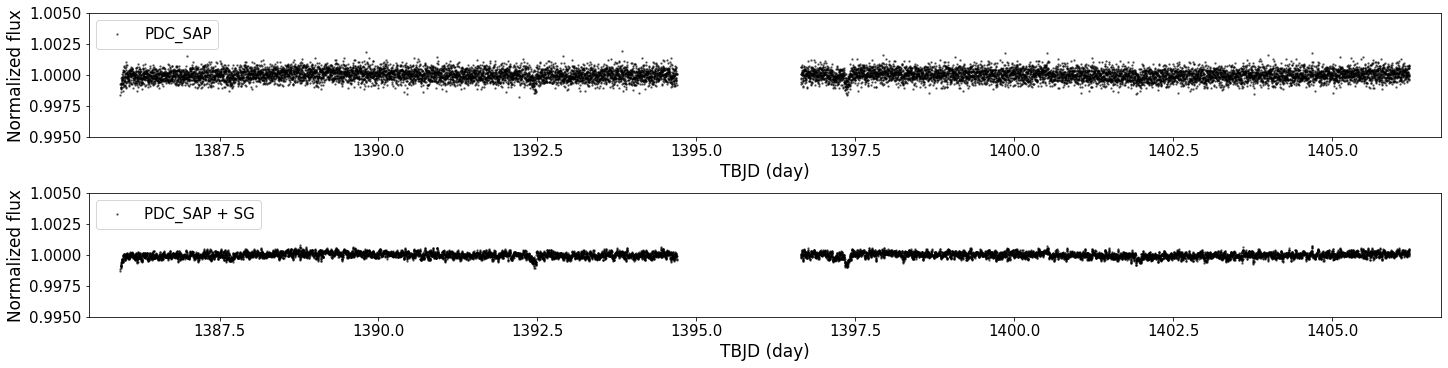

In [4]:
#Let's plot the data 

color1='black'
color2='firebrick'


fig1, (ax1,ax2) = plt.subplots(2, 1, figsize=(20,5),constrained_layout=True)
fig1.patch.set_facecolor('xkcd:white')
props = dict(boxstyle='round', facecolor='beige', alpha=0.5)

ax1.scatter(flux_clean.time.value, flux_clean.flux.value, color=color1, s=2, alpha=0.5,rasterized=True,label='PDC_SAP')
ax1.set_xlim(lcf_120[0]['time'][0].value-0.5,lcf_120[0]['time'][-1].value+0.5)
ax1.set_ylim(0.995,1.005)
ax1.set_ylabel('Normalized flux',fontsize=17)
ax1.set_xlabel('TBJD (day)',fontsize=17)
ax1.tick_params(axis='both', which='major', labelsize=15)

ax2.scatter(flux_clean.time.value, sg, color=color1, s=2, alpha=0.5,rasterized=True,label='PDC_SAP + SG')
ax2.set_xlim(lcf_120[0]['time'][0].value-0.5,lcf_120[0]['time'][-1].value+0.5)
ax2.set_ylim(0.995,1.005)
ax2.set_ylabel('Normalized flux',fontsize=17)
ax2.set_xlabel('TBJD (day)',fontsize=17)
ax2.tick_params(axis='both', which='major', labelsize=15)

# Add legends
ax1.legend(fontsize=15,loc='upper left')
ax2.legend(fontsize=15,loc='upper left')

In [5]:
# To optimize the search we need some stellar parameters, which we import from the TESS imput catalogue 

ab, mass, mass_lower, mass_upper, radius, radius_lower, radius_upper = catalog_info(TIC_ID=TIC_ID)

mass_min=mass-mass_lower
mass_max=mass+mass_upper
radius_min=radius-radius_lower
radius_max=radius+radius_upper

print('\n STELLAR PROPERTIES (IN SOLAR UNITS) FOR THE SIGNAL SEARCH')
print('====================================================================\n')
print('limb-darkening estimates using quadratic LD (a,b)=', ab)
print('mass =', mass)
print('mass_min =', mass_min)
print('mass_max =', mass_max)
print('radius =', radius)
print('radius_min =', radius_min)
print('radius_max =', radius_max)


 STELLAR PROPERTIES (IN SOLAR UNITS) FOR THE SIGNAL SEARCH

limb-darkening estimates using quadratic LD (a,b)= (0.4136, 0.1999)
mass = 0.88
mass_min = 0.769413
mass_max = 0.990587
radius = 0.841842
radius_min = 0.8000003
radius_max = 0.8836837


In [6]:
# Now we run the TLS algorithm to search for planetary candidates using the PDC_SAP light curve

model = transitleastsquares(flux_clean.time.value, flux_clean.flux.value)
results = model.power(u=ab, M_star=mass, M_star_min=mass_min, M_star_max=mass_max, R_star=radius, R_star_min=radius_min, R_star_max=radius_max, n_transits_min=2, show_progress_bar=True,oversampling_factor=3)

Transit Least Squares TLS 1.0.42 (12 April 2023)


  0%|          | 0/2204 periods | 00:00<?

Creating model cache for 36 durations
Searching 13032 data points, 2204 periods from 0.495 to 10.139 days
Using all 8 CPU threads


100%|██████████| 2204/2204 periods | 00:36<00:00


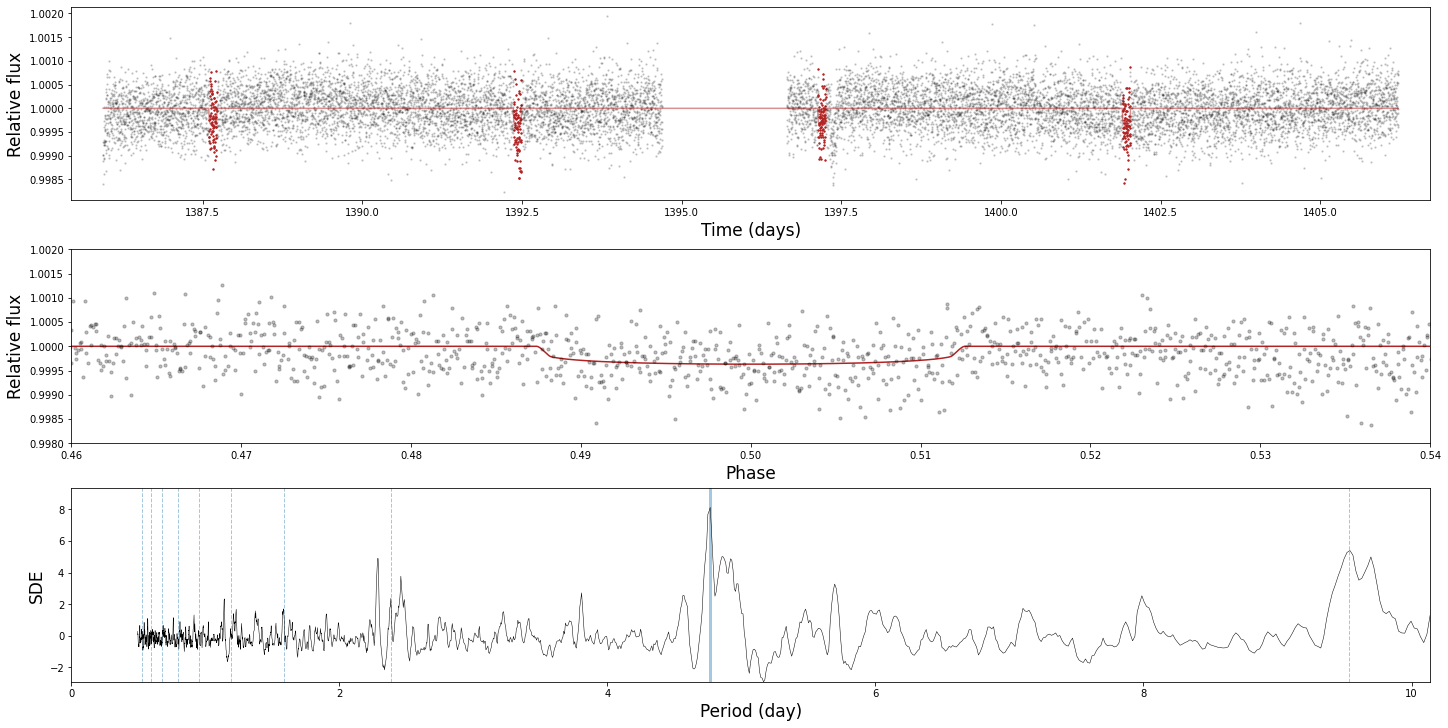

In [7]:
# let's now to explore the results 

fig1, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(20,10),constrained_layout=True)
fig1.patch.set_facecolor('xkcd:white')

# let's see which transits were found 
in_transit = transit_mask(flux_clean.time.value, results.period, results.duration, results.T0)
ax1.scatter(flux_clean.time.value[in_transit], flux_clean.flux.value[in_transit], color=color2, s=2, zorder=0)
ax1.scatter(flux_clean.time.value[~in_transit], flux_clean.flux.value[~in_transit], color=color1, alpha=0.15, s=2, zorder=0)
ax1.plot(results.model_lightcurve_time, results.model_lightcurve_model, alpha=0.5, color=color2, zorder=1)
ax1.set_xlim(lcf_120[0]['time'][0].value-0.5,lcf_120[0]['time'][-1].value+0.5)
ax1.set_ylabel('Relative flux',fontsize=17)
ax1.set_xlabel('Time (days)',fontsize=17)

# transit phase folded
ax2.plot(results.model_folded_phase, results.model_folded_model, color=color2)
ax2.scatter(results.folded_phase, results.folded_y, color=color1, s=10, alpha=0.25, zorder=2)
ax2.set_xlim(0.46, 0.54)
ax2.set_ylim(0.998, 1.002)
ax2.set_ylabel('Relative flux',fontsize=17)
ax2.set_xlabel('Phase',fontsize=17)

# SDE spectrum
ax3.axvline(results.period, alpha=0.4, lw=3)
ax3.set_ylim(np.min(results.power), np.max(results.power)*1.15)
for n in range(2, 10):
    ax3.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
    ax3.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")

ax3.set_ylabel('SDE',fontsize=17)
ax3.set_xlabel('Period (day)',fontsize=17)
ax3.plot(results.periods, results.power, color='black', lw=0.5)
ax3.set_xlim(0, max(results.periods));

In [8]:
# Now we run the TLS algorithm to search for planetary candidates using the PDC_SAP light curve when the SG filter has been previously applied (mimicking the SHERLOCK algorithm)

model_sg = transitleastsquares(flux_clean.time.value, sg)
results_sg = model_sg.power(u=ab, M_star=mass, M_star_min=mass_min, M_star_max=mass_max, R_star=radius, R_star_min=radius_min, R_star_max=radius_max, n_transits_min=2, show_progress_bar=True, oversampling_factor=3)

  0%|          | 0/2204 periods | 00:00<?

Transit Least Squares TLS 1.0.42 (12 April 2023)
Creating model cache for 36 durations
Searching 13032 data points, 2204 periods from 0.495 to 10.139 days
Using all 8 CPU threads


100%|██████████| 2204/2204 periods | 00:36<00:00


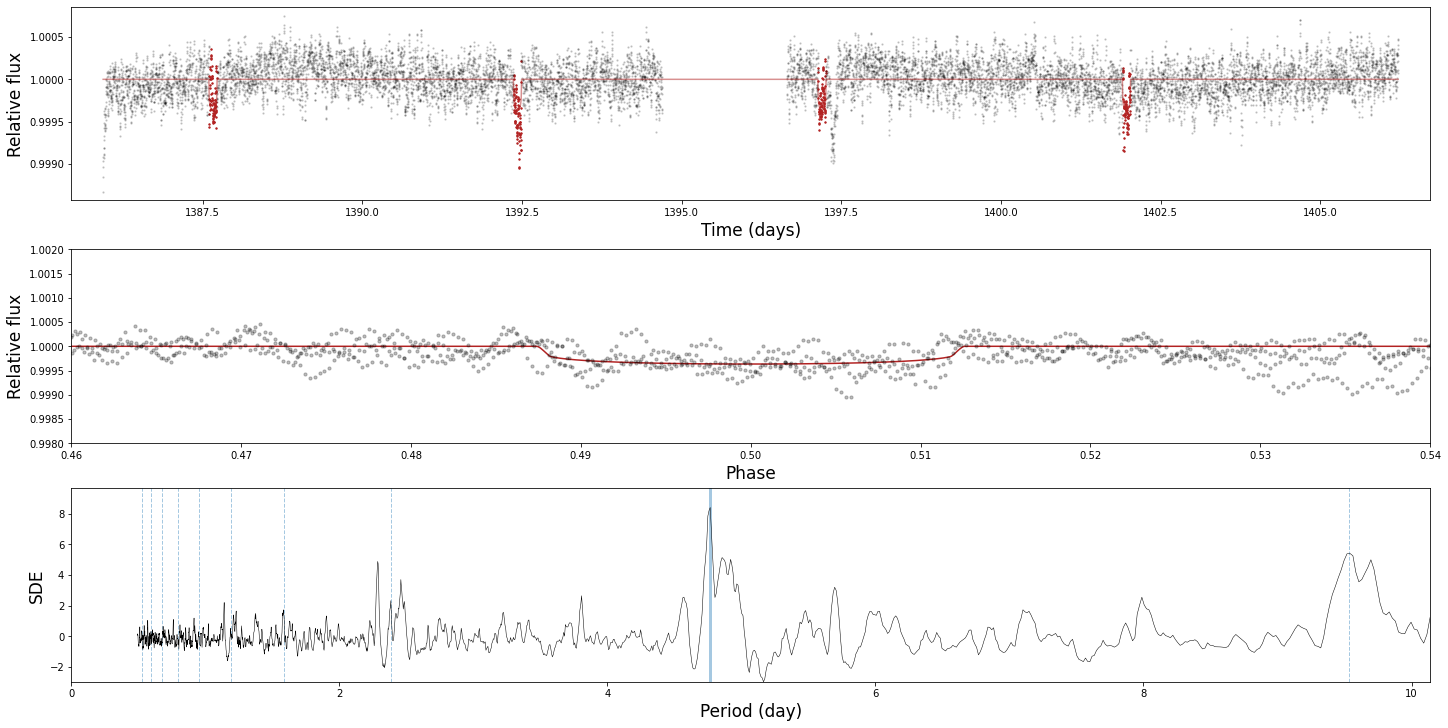

In [9]:
# let's now to explore the results 

fig1, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(20,10),constrained_layout=True)
fig1.patch.set_facecolor('xkcd:white')

# let's see which transits were found 
in_transit = transit_mask(flux_clean.time.value, results_sg.period, results_sg.duration, results.T0)
ax1.scatter(flux_clean.time.value[in_transit], sg[in_transit], color=color2, s=2, zorder=0)
ax1.scatter(flux_clean.time.value[~in_transit], sg[~in_transit], color=color1, alpha=0.15, s=2, zorder=0)
ax1.plot(results_sg.model_lightcurve_time, results_sg.model_lightcurve_model, alpha=0.5, color=color2, zorder=1)
ax1.set_xlim(lcf_120[0]['time'][0].value-0.5,lcf_120[0]['time'][-1].value+0.5)
ax1.set_ylabel('Relative flux',fontsize=17)
ax1.set_xlabel('Time (days)',fontsize=17)

# transit phase folded
ax2.plot(results_sg.model_folded_phase, results_sg.model_folded_model, color=color2)
ax2.scatter(results_sg.folded_phase, results_sg.folded_y, color=color1, s=10, alpha=0.25, zorder=2)
ax2.set_xlim(0.46, 0.54)
ax2.set_ylim(0.998, 1.002)
ax2.set_ylabel('Relative flux',fontsize=17)
ax2.set_xlabel('Phase',fontsize=17)

# SDE spectrum
ax3.axvline(results_sg.period, alpha=0.4, lw=3)
ax3.set_ylim(np.min(results_sg.power), np.max(results_sg.power)*1.15)
for n in range(2, 10):
    ax3.axvline(n*results_sg.period, alpha=0.4, lw=1, linestyle="dashed")
    ax3.axvline(results_sg.period / n, alpha=0.4, lw=1, linestyle="dashed")

ax3.set_ylabel('SDE',fontsize=17)
ax3.set_xlabel('Period (day)',fontsize=17)
ax3.plot(results_sg.periods, results_sg.power, color='black', lw=0.5)
ax3.set_xlim(0, max(results_sg.periods));

In [10]:
# let's compare the metrics of both methods to see what we obatain

print('**USING THE TLS ALGORITHM OVER THE PDC_SAP LIGHTCURVE**')
print('')
print('Period', format(results.period, '.5f'), 'd at T0=', results.T0)
print(len(results.transit_times), 'transit times in time series:', ['{0:0.5f}'.format(i) for i in results.transit_times])
print('Number of data points during each unique transit: ', results.per_transit_count)
print('The number of transits with intransit data points: ', results.distinct_transit_count)
print('The number of transits with no intransit data points: ', results.empty_transit_count)
print('Transit depth (mean): ', format(np.nanmean(results.transit_depths), '.5f'))
print('Transit duration (min): ', format(results.duration*24*60, '.5f'))
print('Transit depths (individual): ', results.transit_depths)
print('Transit depth uncertainties: ', results.transit_depths_uncertainties)
print('Signal-to-Noise (S/N): ', results.snr)
print('Signal-Detection-Efficiency (SDE): ', results.SDE)

print('')
print('')

print('**USING THE TLS ALGORITHM OVER THE PDC_SAP+SG (SHERLOCK LIKE)**')
print('')
print('Period', format(results_sg.period, '.5f'), 'd at T0=', results_sg.T0)
print(len(results_sg.transit_times), 'transit times in time series:', ['{0:0.5f}'.format(i) for i in results_sg.transit_times])
print('Number of data points during each unique transit: ', results_sg.per_transit_count)
print('The number of transits with intransit data points: ', results_sg.distinct_transit_count)
print('The number of transits with no intransit data points: ', results_sg.empty_transit_count)
print('Transit depth (mean): ', format(np.nanmean(results_sg.transit_depths), '.5f'))
print('Transit duration (min): ', format(results_sg.duration*24*60, '.5f'))
print('Transit depths (individual): ', results_sg.transit_depths)
print('Transit depth uncertainties: ', results_sg.transit_depths_uncertainties)
print('Signal-to-Noise (S/N): ', results_sg.snr)
print('Signal-Detection-Efficiency (SDE): ', results_sg.SDE)


**USING THE TLS ALGORITHM OVER THE PDC_SAP LIGHTCURVE**

Period 4.76767 d at T0= 1387.6586133145286
4 transit times in time series: ['1387.65861', '1392.42628', '1397.19395', '1401.96162']
Number of data points during each unique transit:  [86. 84. 86. 84.]
The number of transits with intransit data points:  4
The number of transits with no intransit data points:  0
Transit depth (mean):  0.99970
Transit duration (min):  172.80835
Transit depths (individual):  [0.99978551 0.99957554 0.99976763 0.99965549]
Transit depth uncertainties:  [4.79187696e-05 5.32694928e-05 4.25431403e-05 4.66107060e-05]
Signal-to-Noise (S/N):  12.82264564367609
Signal-Detection-Efficiency (SDE):  8.129407485584178


**USING THE TLS ALGORITHM OVER THE PDC_SAP+SG (SHERLOCK LIKE)**

Period 4.76767 d at T0= 1387.65981001866
4 transit times in time series: ['1387.65981', '1392.42748', '1397.19515', '1401.96282']
Number of data points during each unique transit:  [87. 83. 86. 85.]
The number of transits with intrans

In [ ]:
# We found that almost all the parameters are equal, but when applying the SG filter the transit detection is enhanced, helping to find planets 
# with very shallow transits buried in the noise. However, the SG filter clearly alters the transit shape, hence 
# can not be used when the intention is to conduct a proper transit fitting to derive planet parameters